/opt/homebrew/Caskroom/miniforge/base/envs/fsrs4anki/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


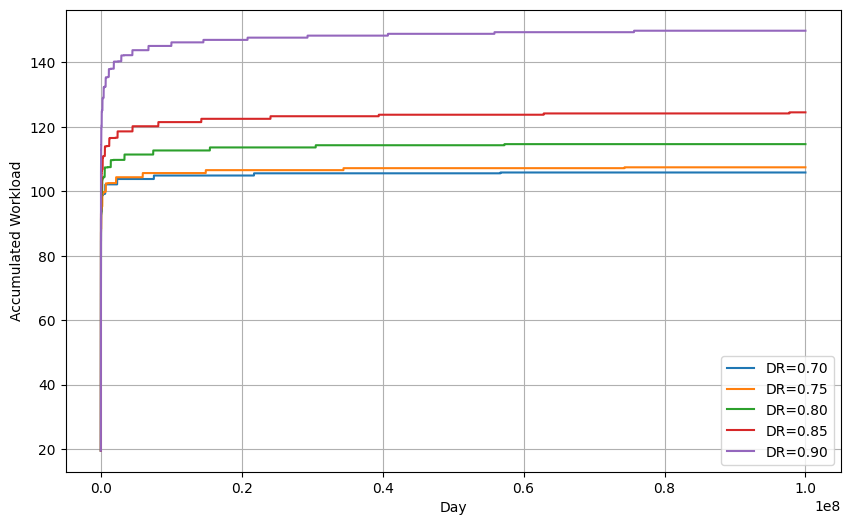

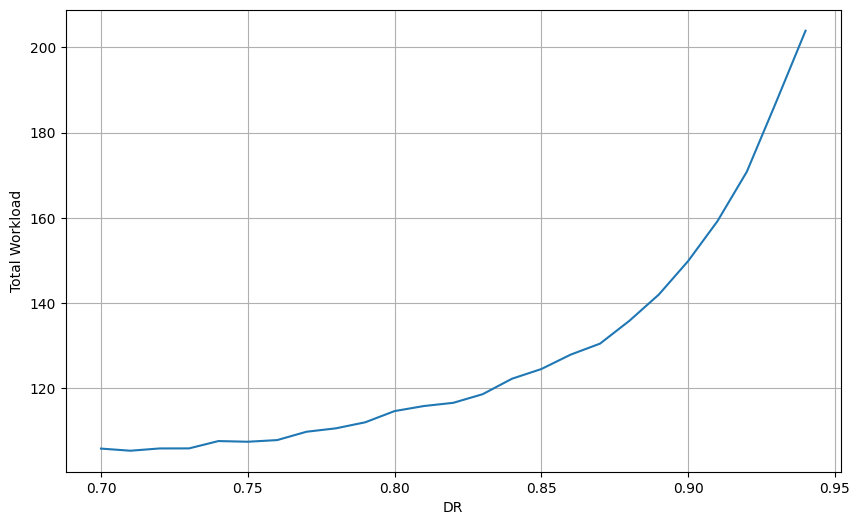

In [1]:
import numpy as np
import matplotlib.pyplot as plt

learn_day_limit = int(1e8)
termination_prob = 0.01

w = [
    0.212,
    1.2931,
    2.3065,
    8.2956,
    6.4133,
    0.8334,
    3.0194,
    0.001,
    1.8722,
    0.1666,
    0.796,
    1.4835,
    0.0614,
    0.2629,
    1.6483,
    0.6014,
    1.8729,
    0.5425,
    0.0912,
    0.0658,
    0.1542,
]
S_MIN = 0.001
FORGET_COST = 23.185
RECALL_COST = 7.8454
LEARN_COST = 19.4698


def stability_after_success(s, r, d, rating):
    hard_penalty = np.where(rating == 2, w[15], 1)
    easy_bonus = np.where(rating == 4, w[16], 1)
    return np.maximum(
        S_MIN,
        s
        * (
            1
            + np.exp(w[8])
            * (11 - d)
            * np.power(s, -w[9])
            * (np.exp((1 - r) * w[10]) - 1)
            * hard_penalty
            * easy_bonus
        ),
    )


def stability_after_failure(s, r, d):
    return np.maximum(
        S_MIN,
        np.minimum(
            w[11]
            * np.power(d, -w[12])
            * (np.power(s + 1, w[13]) - 1)
            * np.exp((1 - r) * w[14]),
            s / np.exp(w[17] * w[18]),
        ),
    )


def init_d(rating):
    return w[4] - np.exp(w[5] * (rating - 1)) + 1


def linear_damping(delta_d, old_d):
    return delta_d * (10 - old_d) / 9


def mean_reversion(init, current):
    return w[7] * init + (1 - w[7]) * current


def next_d(d, rating):
    delta_d = -w[6] * (rating - 3)
    new_d = d + linear_damping(delta_d, d)
    new_d = mean_reversion(init_d(4), new_d)
    return np.clip(new_d, 1, 10)


def power_forgetting_curve(t, s, decay: float = -w[20]):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def next_interval(s, r, decay: float = -w[20]):
    factor = 0.9 ** (1 / decay) - 1
    ivl = s / factor * (r ** (1 / decay) - 1)
    return int(round(max(1, ivl), 0))


def expected_learn(acc_prob, stability, difficulty, day, record, dr, tr, cost):
    if day >= learn_day_limit or acc_prob <= termination_prob:
        return
    record[day] += acc_prob * cost
    if stability > 0:
        s_recall = stability_after_success(stability, tr, difficulty, 3)
        s_forget = stability_after_failure(stability, tr, difficulty)
        d_recall = next_d(difficulty, 3)
        d_forget = next_d(difficulty, 1)
    else:
        s_recall = w[2]
        s_forget = w[0]
        d_recall = init_d(3)
        d_forget = init_d(1)
    ivl_recall = next_interval(s_recall, dr)
    tr_recall = power_forgetting_curve(ivl_recall, s_recall)
    ivl_forget = next_interval(s_forget, dr)
    tr_forget = power_forgetting_curve(ivl_forget, s_forget)
    expected_learn(
        acc_prob * tr,
        s_recall,
        d_recall,
        day + ivl_recall,
        record,
        dr,
        tr_recall,
        RECALL_COST,
    )
    expected_learn(
        acc_prob * (1 - tr),
        s_forget,
        d_forget,
        day + ivl_forget,
        record,
        dr,
        tr_forget,
        FORGET_COST,
    )


workload_list = []

plt.figure(figsize=(10, 6))

R_RANGE = np.arange(0.7, 0.95, 0.01)

for i, dr in enumerate(R_RANGE):
    record = np.zeros(learn_day_limit)
    expected_learn(1, 0, 0, 0, record, dr, 0.8, LEARN_COST)
    if i % 5 == 0:
        plt.plot(np.cumsum(record), label=f"DR={dr:.2f}")
    workload_list.append(np.sum(record))

plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Accumulated Workload")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(R_RANGE, workload_list)
plt.grid(True)
plt.xlabel("DR")
plt.ylabel("Total Workload")
plt.show()